In [5]:
import torch
!pip install ultralytics
import torchvision.transforms as transforms
import ultralytics
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from torchvision import models
from torch import nn
import os
import glob
from PIL import Image
import cv2
import numpy as np

In [8]:
import ultralytics 

# Define paths
KITTI_PATH = "/kaggle/input/kitti-dataset/data_object_image_2/training/image_2"
YOLO_LABELS_PATH = "/kaggle/input/kitti-yolo-labels/labels"
DATA_PATH = "E/kaggle/working/"

# Create dataset directory structure
os.makedirs(f"{DATA_PATH}/images/train", exist_ok=True)
os.makedirs(f"{DATA_PATH}/images/val", exist_ok=True)
os.makedirs(f"{DATA_PATH}/labels/train", exist_ok=True)
os.makedirs(f"{DATA_PATH}/labels/val", exist_ok=True)

# Get image and label files
image_files = sorted([f for f in os.listdir(KITTI_PATH) if f.endswith(".png")])
label_files = sorted([f for f in os.listdir(YOLO_LABELS_PATH) if f.endswith(".txt")])

# Ensure matching images and labels
image_files = [f for f in image_files if f.replace(".png", ".txt") in label_files]

# Split into train and validation sets
train_images, val_images = train_test_split(image_files, test_size=0.2, random_state=42)

In [9]:
# Function to copy files (ensures both images and labels exist)
def copy_files(files, src_img, src_lbl, dst_img, dst_lbl):
    for file in files:
        img_src = os.path.join(src_img, file)
        lbl_src = os.path.join(src_lbl, file.replace(".png", ".txt"))
        img_dst = os.path.join(dst_img, file)
        lbl_dst = os.path.join(dst_lbl, file.replace(".png", ".txt"))
        
        if os.path.exists(lbl_src):  # Copy only if label exists
            shutil.copy(img_src, img_dst)
            shutil.copy(lbl_src, lbl_dst)

# Copy training and validation files
copy_files(train_images, KITTI_PATH, YOLO_LABELS_PATH, f"{DATA_PATH}/images/train", f"{DATA_PATH}/labels/train")
copy_files(val_images, KITTI_PATH, YOLO_LABELS_PATH, f"{DATA_PATH}/images/val", f"{DATA_PATH}/labels/val")

# ✅ Validation: Check for copied files
train_img_count = len(os.listdir(f"{DATA_PATH}/images/train"))
val_img_count = len(os.listdir(f"{DATA_PATH}/images/val"))

print(f"Training images: {train_img_count}")
print(f"Validation images: {val_img_count}")

# Raise an error if validation folder is empty
if val_img_count == 0:
    raise ValueError("Validation folder is empty. Check dataset splitting and file copying.")


Training images: 5984
Validation images: 1497


In [10]:
from ultralytics import YOLO

# Create dataset YAML file
dataset_yaml = f"""
path: {os.path.abspath(DATA_PATH)}
train: {os.path.abspath(DATA_PATH)}/images/train
val: {os.path.abspath(DATA_PATH)}/images/val
names:
  0: car
  1: pedestrian
  2: van
  3: Cyclist
  4: truck
  5: misc
  6: tram
  7: person_sitting
"""
with open(f"{DATA_PATH}/data.yaml", "w") as f:
    f.write(dataset_yaml)

# Train YOLOv11 model
model = YOLO("yolo11n.pt")
model.train(data=f"{DATA_PATH}/data.yaml", epochs=100, imgsz=640, batch=16 , val=True, verbose=True)

New https://pypi.org/project/ultralytics/8.3.106 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.105 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=E/kaggle/working//data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_tx

train: Scanning /kaggle/working/E/kaggle/working/labels/train.cache... 5984 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5984/5984 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/E/kaggle/working/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       2.4G      1.417      1.965      1.089        133        640: 100%|██████████| 374/374 [01:34<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.82it/s]


                   all       1497       8231      0.519      0.321      0.319      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.51G      1.279      1.241      1.058        159        640: 100%|██████████| 374/374 [01:30<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]


                   all       1497       8231      0.517      0.419      0.405       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.51G       1.25      1.107      1.054        136        640: 100%|██████████| 374/374 [01:29<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.83it/s]


                   all       1497       8231      0.578      0.409      0.436       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.51G      1.222      1.015      1.045        150        640: 100%|██████████| 374/374 [01:30<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.43it/s]


                   all       1497       8231      0.509      0.499      0.499        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.51G      1.179     0.9369      1.031        187        640: 100%|██████████| 374/374 [01:29<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.00it/s]


                   all       1497       8231      0.607      0.471      0.523      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.51G      1.155     0.8927      1.024        177        640: 100%|██████████| 374/374 [01:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.01it/s]


                   all       1497       8231      0.598       0.54      0.561      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.51G      1.139     0.8556      1.014        227        640: 100%|██████████| 374/374 [01:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.95it/s]


                   all       1497       8231      0.668      0.514      0.591      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.51G      1.124      0.841      1.011        174        640: 100%|██████████| 374/374 [01:31<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.81it/s]


                   all       1497       8231      0.722       0.54      0.639      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.51G      1.115     0.8186      1.008        114        640: 100%|██████████| 374/374 [01:30<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.02it/s]

                   all       1497       8231      0.685      0.543      0.641      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.51G      1.098     0.7951          1        198        640: 100%|██████████| 374/374 [01:30<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.91it/s]


                   all       1497       8231      0.686      0.604      0.654      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.51G      1.079     0.7724     0.9944        208        640: 100%|██████████| 374/374 [01:27<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.94it/s]


                   all       1497       8231      0.669      0.599       0.66      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.51G      1.069     0.7613     0.9864        131        640: 100%|██████████| 374/374 [01:29<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]


                   all       1497       8231      0.731      0.608       0.69      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.51G      1.059      0.749     0.9871        215        640: 100%|██████████| 374/374 [01:33<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]


                   all       1497       8231      0.758      0.586      0.682      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.51G      1.046     0.7391     0.9857        131        640: 100%|██████████| 374/374 [01:30<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.73it/s]


                   all       1497       8231      0.712      0.636      0.699      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.51G      1.047      0.735     0.9818        164        640: 100%|██████████| 374/374 [01:31<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.93it/s]


                   all       1497       8231      0.721      0.641      0.693      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.51G      1.036     0.7192     0.9803        134        640: 100%|██████████| 374/374 [01:30<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.92it/s]


                   all       1497       8231      0.695      0.646      0.709      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.51G      1.024     0.7062     0.9751        155        640: 100%|██████████| 374/374 [01:27<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]


                   all       1497       8231      0.719      0.637      0.702       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.51G      1.018     0.6973     0.9711        137        640: 100%|██████████| 374/374 [01:30<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]

                   all       1497       8231      0.783      0.652      0.743      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.51G      1.007     0.6886     0.9717        151        640: 100%|██████████| 374/374 [01:30<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.90it/s]


                   all       1497       8231       0.83      0.641      0.751      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.51G      1.006     0.6879     0.9704        166        640: 100%|██████████| 374/374 [01:30<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.92it/s]


                   all       1497       8231      0.799      0.675      0.763      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.63G      0.993      0.672     0.9634        193        640: 100%|██████████| 374/374 [01:30<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.92it/s]


                   all       1497       8231      0.779      0.661      0.749      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.63G     0.9967     0.6733      0.964        164        640: 100%|██████████| 374/374 [01:29<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.01it/s]


                   all       1497       8231      0.818      0.682      0.777      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.63G     0.9864     0.6648     0.9612        185        640: 100%|██████████| 374/374 [01:29<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.46it/s]


                   all       1497       8231       0.81      0.691       0.79      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.63G     0.9888     0.6664     0.9623        134        640: 100%|██████████| 374/374 [01:29<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.89it/s]


                   all       1497       8231      0.812      0.707       0.78      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.63G     0.9732     0.6552     0.9577        217        640: 100%|██████████| 374/374 [01:31<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.88it/s]


                   all       1497       8231      0.833      0.692      0.791      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.63G     0.9631     0.6447     0.9531        137        640: 100%|██████████| 374/374 [01:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.74it/s]


                   all       1497       8231      0.818      0.715      0.793      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.63G      0.963     0.6411     0.9542        104        640: 100%|██████████| 374/374 [01:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.97it/s]


                   all       1497       8231      0.844      0.695      0.796       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.63G     0.9522     0.6341     0.9475        168        640: 100%|██████████| 374/374 [01:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.93it/s]

                   all       1497       8231      0.812      0.727      0.799      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.63G      0.948     0.6306     0.9487        172        640: 100%|██████████| 374/374 [01:29<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.95it/s]


                   all       1497       8231      0.802      0.708      0.798      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.63G     0.9442     0.6262     0.9467        168        640: 100%|██████████| 374/374 [01:27<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.88it/s]

                   all       1497       8231      0.844      0.709      0.806      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.63G     0.9405     0.6202     0.9443        208        640: 100%|██████████| 374/374 [01:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.92it/s]


                   all       1497       8231      0.833      0.714      0.811      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.63G     0.9431     0.6231     0.9439        130        640: 100%|██████████| 374/374 [01:30<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.81it/s]


                   all       1497       8231      0.807      0.726       0.81      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.63G     0.9329     0.6095      0.941        196        640: 100%|██████████| 374/374 [01:30<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.96it/s]


                   all       1497       8231      0.832      0.738      0.814      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.63G     0.9302     0.6116     0.9417        143        640: 100%|██████████| 374/374 [01:30<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.96it/s]


                   all       1497       8231       0.83      0.747      0.818      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.63G     0.9178      0.601     0.9371        133        640: 100%|██████████| 374/374 [01:29<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.99it/s]


                   all       1497       8231      0.839      0.742       0.82      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.63G     0.9153     0.5956     0.9371        177        640: 100%|██████████| 374/374 [01:28<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.02it/s]


                   all       1497       8231      0.824      0.751      0.824      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.63G     0.9075     0.5925     0.9344        167        640: 100%|██████████| 374/374 [01:30<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.96it/s]


                   all       1497       8231      0.839      0.742      0.817      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.63G     0.9058     0.5902     0.9333        202        640: 100%|██████████| 374/374 [01:29<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]


                   all       1497       8231      0.832      0.732      0.817      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.63G     0.9058     0.5926     0.9345        141        640: 100%|██████████| 374/374 [01:30<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.94it/s]


                   all       1497       8231      0.857       0.74      0.829      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.63G     0.9014     0.5851     0.9327        137        640: 100%|██████████| 374/374 [01:30<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.93it/s]


                   all       1497       8231      0.861      0.762      0.844      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.63G     0.8827     0.5757     0.9266        169        640: 100%|██████████| 374/374 [01:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.99it/s]


                   all       1497       8231      0.852       0.77      0.835       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.63G     0.8898     0.5741     0.9278        189        640: 100%|██████████| 374/374 [01:29<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.42it/s]


                   all       1497       8231      0.858      0.771      0.846      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.63G     0.8905     0.5763     0.9259        178        640: 100%|██████████| 374/374 [01:29<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]


                   all       1497       8231      0.843      0.769      0.839      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.63G     0.8779     0.5689     0.9249        210        640: 100%|██████████| 374/374 [01:30<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.83it/s]


                   all       1497       8231      0.873      0.759      0.847      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.63G     0.8754     0.5646      0.922        141        640: 100%|██████████| 374/374 [01:29<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.01it/s]

                   all       1497       8231      0.847      0.776      0.854      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.63G     0.8739     0.5623     0.9233        146        640: 100%|██████████| 374/374 [01:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.97it/s]


                   all       1497       8231      0.853      0.783      0.857        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.63G     0.8696     0.5622     0.9225        148        640: 100%|██████████| 374/374 [01:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.05it/s]


                   all       1497       8231      0.889      0.752      0.849      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.63G     0.8662     0.5574     0.9203        133        640: 100%|██████████| 374/374 [01:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.90it/s]


                   all       1497       8231      0.872      0.768      0.859      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.63G     0.8582     0.5511     0.9163        172        640: 100%|██████████| 374/374 [01:27<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]


                   all       1497       8231       0.89      0.752      0.862      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.63G     0.8547     0.5507     0.9169        158        640: 100%|██████████| 374/374 [01:29<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.82it/s]


                   all       1497       8231      0.848      0.777      0.853      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.63G     0.8542     0.5436     0.9135        164        640: 100%|██████████| 374/374 [01:29<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.93it/s]


                   all       1497       8231      0.885      0.761      0.865       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.63G     0.8547     0.5474     0.9137        201        640: 100%|██████████| 374/374 [01:30<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.98it/s]


                   all       1497       8231       0.88      0.776      0.864      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.63G     0.8464     0.5401     0.9141        193        640: 100%|██████████| 374/374 [01:29<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.98it/s]


                   all       1497       8231      0.858      0.779      0.868      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.63G     0.8385     0.5374     0.9097        178        640: 100%|██████████| 374/374 [01:30<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.98it/s]


                   all       1497       8231       0.87      0.783       0.87      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.63G     0.8377      0.535       0.91        126        640: 100%|██████████| 374/374 [01:27<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.81it/s]


                   all       1497       8231      0.861      0.789      0.866      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.63G     0.8371      0.534      0.911        217        640: 100%|██████████| 374/374 [01:29<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.82it/s]

                   all       1497       8231       0.85      0.802      0.867      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.63G     0.8301     0.5279      0.908        170        640: 100%|██████████| 374/374 [01:30<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.89it/s]


                   all       1497       8231      0.887       0.78      0.874      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.63G     0.8275     0.5281     0.9075        138        640: 100%|██████████| 374/374 [01:29<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]


                   all       1497       8231      0.894      0.775      0.874      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.63G      0.824     0.5269     0.9067        190        640: 100%|██████████| 374/374 [01:30<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.97it/s]


                   all       1497       8231      0.865      0.797      0.879       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.63G     0.8209     0.5235     0.9064        138        640: 100%|██████████| 374/374 [01:30<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.89it/s]


                   all       1497       8231      0.898      0.788      0.879      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.63G     0.8185     0.5198     0.9053        188        640: 100%|██████████| 374/374 [01:30<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.22it/s]


                   all       1497       8231      0.876      0.801      0.872      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.63G     0.8206     0.5234     0.9044        202        640: 100%|██████████| 374/374 [01:28<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.80it/s]


                   all       1497       8231      0.866      0.806      0.875      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.63G     0.8132     0.5165     0.9023        173        640: 100%|██████████| 374/374 [01:30<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.84it/s]


                   all       1497       8231      0.868      0.801      0.872      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.63G     0.8083     0.5155     0.9009        199        640: 100%|██████████| 374/374 [01:30<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.06it/s]


                   all       1497       8231      0.865      0.819       0.88      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.63G     0.8069      0.513     0.9005        166        640: 100%|██████████| 374/374 [01:29<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.94it/s]


                   all       1497       8231      0.863       0.81      0.881      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.63G     0.8095     0.5129     0.9024        124        640: 100%|██████████| 374/374 [01:30<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.97it/s]

                   all       1497       8231      0.893       0.78      0.881       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.63G     0.7994     0.5078     0.8983        204        640: 100%|██████████| 374/374 [01:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.92it/s]

                   all       1497       8231      0.877      0.799      0.883      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.63G     0.7985     0.5049     0.8969        193        640: 100%|██████████| 374/374 [01:29<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.92it/s]


                   all       1497       8231        0.9      0.792       0.88      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.63G     0.7918     0.5024     0.8973        156        640: 100%|██████████| 374/374 [01:30<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.93it/s]


                   all       1497       8231      0.906      0.803      0.886      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.63G     0.7892     0.5009     0.8948        165        640: 100%|██████████| 374/374 [01:31<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.02it/s]


                   all       1497       8231      0.888      0.796      0.882       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.63G     0.7906     0.4989     0.8947        202        640: 100%|██████████| 374/374 [01:30<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.97it/s]


                   all       1497       8231      0.887      0.807      0.884      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.63G     0.7815     0.4933     0.8941        217        640: 100%|██████████| 374/374 [01:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.98it/s]


                   all       1497       8231      0.887      0.802      0.884      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.63G     0.7781     0.4916     0.8934        213        640: 100%|██████████| 374/374 [01:29<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.91it/s]


                   all       1497       8231       0.88      0.816      0.886      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.63G     0.7796     0.4937     0.8925        166        640: 100%|██████████| 374/374 [01:26<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]


                   all       1497       8231      0.877      0.817      0.885      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.63G     0.7755     0.4897      0.892        248        640: 100%|██████████| 374/374 [01:29<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.90it/s]


                   all       1497       8231      0.884      0.815      0.889      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.63G     0.7699      0.487     0.8911        159        640: 100%|██████████| 374/374 [01:29<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.93it/s]


                   all       1497       8231      0.877      0.806      0.885       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.63G     0.7698     0.4893     0.8904        181        640: 100%|██████████| 374/374 [01:30<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]

                   all       1497       8231      0.895      0.807      0.889      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.63G     0.7664     0.4842     0.8901        188        640: 100%|██████████| 374/374 [01:31<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.97it/s]


                   all       1497       8231      0.896      0.808      0.888      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.63G     0.7615     0.4805     0.8876        183        640: 100%|██████████| 374/374 [01:30<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.94it/s]


                   all       1497       8231      0.896      0.807      0.887      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.63G     0.7583     0.4789     0.8873        144        640: 100%|██████████| 374/374 [01:30<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.15it/s]

                   all       1497       8231      0.889      0.824      0.892      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.63G     0.7563      0.478     0.8868        151        640: 100%|██████████| 374/374 [01:28<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]


                   all       1497       8231       0.89      0.822      0.892      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.63G     0.7565     0.4781     0.8865        178        640: 100%|██████████| 374/374 [01:30<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.03it/s]


                   all       1497       8231      0.894      0.818      0.893       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.63G     0.7499     0.4748     0.8846        147        640: 100%|██████████| 374/374 [01:30<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.94it/s]


                   all       1497       8231      0.869      0.829      0.896      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.63G       0.75     0.4723     0.8829        169        640: 100%|██████████| 374/374 [01:29<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.05it/s]


                   all       1497       8231      0.897      0.809      0.891      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.63G     0.7423      0.469      0.882        155        640: 100%|██████████| 374/374 [01:30<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.05it/s]


                   all       1497       8231      0.904      0.808      0.895      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.63G     0.7465     0.4708     0.8834        145        640: 100%|██████████| 374/374 [01:30<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.90it/s]


                   all       1497       8231      0.877      0.826      0.896      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.63G     0.7443     0.4706     0.8832        167        640: 100%|██████████| 374/374 [01:27<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.86it/s]


                   all       1497       8231      0.903      0.817      0.897      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.63G     0.7395     0.4674     0.8806        158        640: 100%|██████████| 374/374 [01:29<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.89it/s]


                   all       1497       8231      0.915      0.811      0.897      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.63G     0.7338     0.4631     0.8802        222        640: 100%|██████████| 374/374 [01:30<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.98it/s]


                   all       1497       8231      0.889       0.82      0.895      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.63G     0.7332     0.4621     0.8801        169        640: 100%|██████████| 374/374 [01:30<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.93it/s]


                   all       1497       8231      0.882      0.826      0.897      0.663
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.63G     0.7121      0.439       0.87         94        640: 100%|██████████| 374/374 [01:28<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.91it/s]


                   all       1497       8231      0.893       0.82      0.891       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.63G     0.6928      0.427     0.8627        105        640: 100%|██████████| 374/374 [01:27<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.90it/s]

                   all       1497       8231      0.898       0.82      0.893      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.63G     0.6892     0.4245      0.864         70        640: 100%|██████████| 374/374 [01:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.22it/s]


                   all       1497       8231      0.889       0.83      0.896      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.63G     0.6837      0.423     0.8609        110        640: 100%|██████████| 374/374 [01:27<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.03it/s]


                   all       1497       8231      0.887      0.826      0.897      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.63G     0.6807     0.4211     0.8603         78        640: 100%|██████████| 374/374 [01:26<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.03it/s]


                   all       1497       8231      0.895      0.826      0.898      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.63G     0.6724      0.416     0.8602         89        640: 100%|██████████| 374/374 [01:27<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.92it/s]


                   all       1497       8231      0.886      0.835      0.896      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.63G     0.6663     0.4126      0.858         76        640: 100%|██████████| 374/374 [01:26<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]


                   all       1497       8231      0.883      0.834      0.898       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.63G     0.6676     0.4126      0.858         60        640: 100%|██████████| 374/374 [01:26<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]


                   all       1497       8231      0.874       0.84      0.896       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.63G     0.6659     0.4121     0.8555         62        640: 100%|██████████| 374/374 [01:27<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]

                   all       1497       8231      0.882      0.832      0.893      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.63G     0.6628     0.4117      0.857         88        640: 100%|██████████| 374/374 [01:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.87it/s]


                   all       1497       8231      0.877       0.84      0.897      0.672

100 epochs completed in 2.844 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.4MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.105 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,712 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.78it/s]


                   all       1497       8231      0.874       0.84      0.896      0.672
                   car       1338       5889      0.912       0.92      0.966        0.8
            pedestrian        359        916      0.831      0.714      0.816      0.482
                   van        427        570      0.905        0.9      0.956      0.773
               Cyclist        222        308      0.907      0.788      0.873      0.593
                 truck        220        227      0.965      0.962      0.981      0.824
                  misc        156        187      0.805       0.84       0.88      0.686
                  tram         62         95      0.915      0.895      0.941      0.738
        person_sitting         20         39      0.753      0.704      0.759      0.481


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e8755e12c20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

In [11]:
metrics = model.val()
# Print precision, recall, mAP@50, and mAP@50-95
print(f"Precision: {metrics.box.mp:.4f}")  # Mean precision
print(f"Recall: {metrics.box.mr:.4f}")  # Mean recall
print(f"mAP@50: {metrics.box.map50:.4f}")  # Mean AP at IoU 0.5
print(f"mAP@50-95: {metrics.box.map:.4f}")  # Mean AP from 0.5 to 0.95

Ultralytics 8.3.105 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,712 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/E/kaggle/working/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:14<00:00,  6.62it/s]


                   all       1497       8231      0.878       0.84      0.897      0.674
                   car       1338       5889      0.912       0.92      0.966      0.801
            pedestrian        359        916      0.833      0.715      0.817      0.481
                   van        427        570      0.906        0.9      0.957      0.778
               Cyclist        222        308      0.913      0.788      0.872      0.597
                 truck        220        227      0.965      0.962      0.981      0.827
                  misc        156        187      0.809       0.84       0.88      0.687
                  tram         62         95      0.915      0.895      0.941      0.742
        person_sitting         20         39      0.774      0.702      0.762      0.481


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train22
Precision: 0.8784
Recall: 0.8402
mAP@50: 0.8970
mAP@50-95: 0.6743



image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000061.png: 224x640 3 cars, 2 vans, 3 miscs, 74.7ms
Speed: 1.6ms preprocess, 74.7ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)


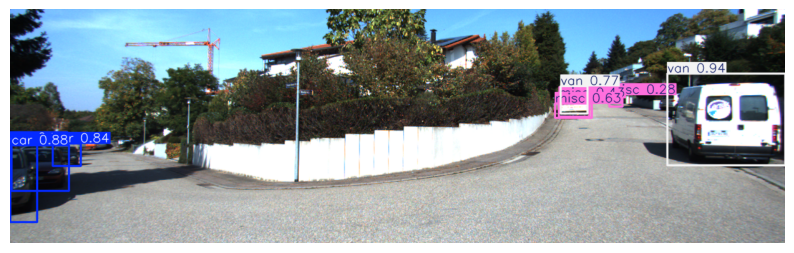

In [12]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load trained YOLOv8 model
model = YOLO("runs/detect/train/weights/best.pt")  # Change path if needed

# Load and run inference on the test image
image_path = "/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000061.png"  # Change to your image path
results = model(image_path)

# Display results
for r in results:
    img_with_boxes = r.plot()  # Draw detected objects on the image

# Convert BGR to RGB for correct display in Matplotlib
img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")  # Hide axes
plt.show()
